In [50]:
#Numerical python, multidimensional array
#Useful for linear algebra operations
import numpy as np 
#pyplot collection of functions in the popular visualization 
#package Matplotlib
import matplotlib.pyplot as plt 
#The "layer call" action is like drawing an 
#arrow from inputs/previous layer output 
#to the layer we'll create in the defining model section
#Functional API
from keras.layers import  Input,Conv2D,MaxPool2D, UpSampling2D,Dense, Dropout 

#Model groups layers into an object with training and 
#inference features
import tensorflow as tf
from keras.models import Model
from keras.datasets import mnist, cifar10
#displays output inline
%matplotlib inline 

In [51]:
#presprocess the images for grey and color types
def preprocess(array1, array2, channel):
    """
    Normalizes/scales [0,1], divinding by the supplied array and reshapes 
    it into the appropriate format.
    """

    
    if channel==1:
        #here -1 refers to the number of rows(n), n*784
        #on this array
        ar1 = array1.astype('float32').reshape([-1,28,28,1]) / 255.
        ar2 = array2.astype('float32').reshape([-1,28,28,1]) / 255.
    else:
        ar1 = array1.astype('float32').reshape([-1,32,32,3]) / 255
        ar2 = array2.astype('float32').reshape([-1,32,32,3]) / 255
    return ar1, ar2

Adding Noise
To add noise we can generate array with same dimension of our images with random values between [0,1] using normal distribution with mean = 0 and standard deviation = 1.

To generate normal distribution, we can use [np.random.normal(loc,scale,size)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html). Then scale the noise by some factor, here I am using 0.3. After adding noise, pixel values can be out of range [0,1], so we need to clip the values using [np.clip(arr, arr_min, arr_max )](https://numpy.org/doc/stable/reference/generated/numpy.clip.html).

In [52]:
def noise(a1,a2, channel):
    """
    Adds random noise to each image in the supplied array.
    """
    if channel==1:
        # Adding noise by multiplication of noise factor and 
        #gaussian distribution
        noise_factor = 0.2
        noisy_arr1 = a1 + noise_factor * np.random.normal(
        0.0, 1.0, size=a1.shape)
        noisy_arr2 = a2 + noise_factor * np.random.normal(
        0.0, 1.0, size=a2.shape)
    else:
        
        noi = 0.1
        noisy_arr1 = a1 + noi * np.random.normal(
        0.0, 1.0, size=a1.shape)
        noisy_arr2 = a2 + noi * np.random.normal(
        0.0, 1.0, size=a2.shape) 
        
    #pixel value not in ranged [0,1] cliped 
    ab1 = np.clip(noisy_arr1, 0, 1)
    ab2 = np.clip(noisy_arr2, 0, 1)
    return ab1, ab2

In [53]:
# Visualization for mnist, cifar10, noisy, denoised/predictions data
def display(rows, cols, a, b, check=False ):
    '''rows: defining no. of rows in figure
      cols: defining no. of colums in figure
      a: train images without noise or noisy_image while test
      prediction
      b: train images with noise or denoised_image based while test 
      prediction
      check: default False for 32*32 cifar10, true for 28*28
      mnist dataset and any predictions
    '''
    # defining a figure 
    f = plt.figure(figsize=(2*cols,2*rows*2)) 
    for i in range(rows):
        for j in range(cols):
            # adding subplot to figure on each iteration
            f.add_subplot(rows*2,cols, (2*i*cols)+(j+1))
            if check:
                plt.imshow(a[i*cols + j].reshape([28,28]),cmap="Blues")
            else:
                plt.imshow(a[i*cols + j])
            plt.axis("off")
        for j in range(cols):
            # adding subplot to figure on each iteration
            f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) 
            if check:
                plt.imshow(b[i*cols + j].reshape([28,28]),cmap="Blues")
            else:
                plt.imshow(b[i*cols + j])
            plt.axis("off")
            plt.axis("off")
        
    #f.suptitle("Sample Training Data",fontsize=18)
    plt.savefig("ss.png")
    plt.show()

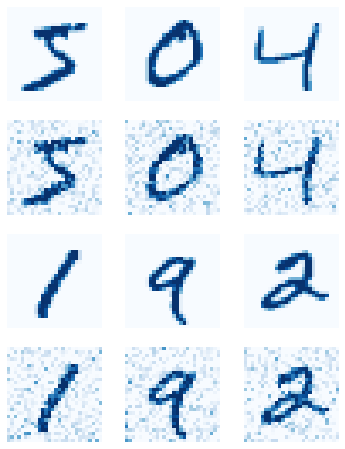

In [54]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels, 50k for train, 10k for test
(train_data, _), (test_data, _) = mnist.load_data()
channel=1
# Normalize and reshape the data
train_data, test_data = preprocess(train_data,test_data,channel)

# Create a copy of the data with added noise
noisy_train_data, noisy_test_data = noise(train_data,test_data,channel)


# Display the train data and a version of it with added noise
display(2,3,train_data, noisy_train_data, check=True)

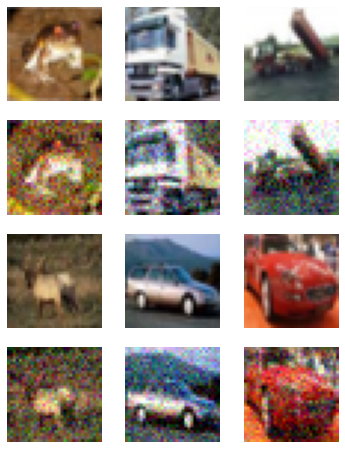

In [55]:
#same as befor 50k for train and 10k test
(cifar_train, _), (cifar_test, _) = cifar10.load_data()
rows=2
cols=3
channel = 3

# Normalize and reshape the data
cifar_train, cifar_test = preprocess(cifar_train,cifar_test, channel)

# Create a copy of the data with added noise
cifar_train_noise, cifar_test_noise = noise(cifar_train,cifar_test, channel)

#display train image with and without noise
display(rows, cols, cifar_train,cifar_train_noise )




# [Autoencoder Model](https://afagarap.works/2019/03/20/implementing-autoencoder-in-tensorflow-2.0.html)
The process of choosing the important parts of the data is known as feature selection, which is among the number of use cases for an autoencoder.
A neural network is a computational model that is used for finding a function describing the relationship between data features x and its values (a regression task) or labels (a classification task) y, i.e. y=f(x). 

Now, an autoencoder is also a neural network. But instead of finding the function mapping the features x to their corresponding values or labels y, it aims to find the function mapping the features 
x to itself x <br>
![image](https://afagarap.works/images/autoencoder.png)

Autoencoder consists of two parts:
1. **Encoder:**  Similar to a conventional feed-forward network, Which learns the data representation, i.e. the important features z of the data instead of label.
2. **Decoder:**  Similar to a feed-forward network. However, instead of reducing data to a lower dimension like encoder, it reconstructs the data from its lower dimension representation z to its original dimension x. Which reconstructs the data based on its idea z of how it is structured.

Mathematically,
z=f(he(x))<br>
x'=f(hd(z))

**Loss Function**,
like other neural networks, an autoencoder learns through backpropagation. However, instead of comparing the values or labels of the model, we compare the reconstructed data 
x' and the original data x. Let’s call this comparison the reconstruction error function. And it's Mean Squred Error! 


 





**How UpSampling2D works:**
The input image of shape 2x2 will be 4x4, like the example below.
```
Input = [
         [1, 2],
         [3, 4]
        ]

Output =  [
           [1, 1, 2, 2],
           [1, 1, 2, 2],
           [3, 3, 4, 4],
           [3, 3, 4, 4]
          ]
```
This is Functional API of Keras. Deep learning model is usually a directed acyclic graph (DAG) of layers. Functional API is a way to build graphs of layers. 
For more details:
* [Functioanl API](https://keras.io/guides/functional_api/)
* [UpSampling2D](#https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D)

### Encoder & Decoder

In [56]:
# Encoder 
inputs = Input(shape=(28,28,1))
#padding same, as if conv fit with the image
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(x)
x = Dropout(0.2)(x)
#relu removes any negative value after transformation
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPool2D()(x)

#Decoder
x = Conv2D(32, 3, activation='relu', padding='same')(encoded)

#upsampling has no parameter or model weights to learn
#simpy double the size of inputs
x = UpSampling2D()(x) 
#used to prevent overfitting
#actuallay we drop 40% of our neuron/unit in backpropagation 
#updating parameters for other 70% of the unit
x = Dropout(0.2)(x) #l1 & l2 modify cost function but
                    #dropout modify the network itself
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

### Create and compile model

In [57]:

#create a model by specifying inputs and output
from tensorflow.keras import losses

autoencoder1 = Model(inputs, decoded)
#binary cross entropy how close or far from the actual value
#logloss
autoencoder1.compile(optimizer='adam', loss=losses.binary_crossentropy) 

autoencoder1.summary()
#autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 32)          9248

### Training


In [58]:

history1=autoencoder1.fit(noisy_train_data, train_data,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(noisy_test_data, test_data)
               )


Epoch 1/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1681 - val_loss: 0.0918
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0938 - val_loss: 0.0821
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0873 - val_loss: 0.0788
Epoch 4/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0842 - val_loss: 0.0772
Epoch 5/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0825 - val_loss: 0.0764
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0814 - val_loss: 0.0756
Epoch 7/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0805 - val_loss: 0.0752
Epoch 8/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0799 - val_loss: 0.0748
Epoch 9/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0794 - val_loss: 0.0743
Epoch 10/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0789 - val_loss: 0.0740

# Performance/ Visualise Results
Training seems to be great. Loss and validation loss has decreased as expected.

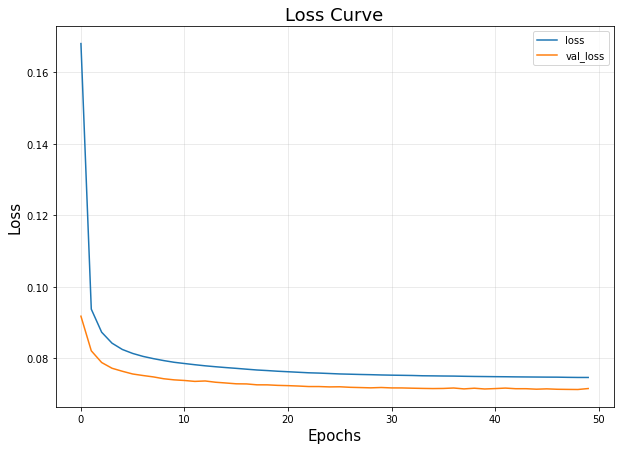

In [59]:
def plot_diag(history):
    f = plt.figure(figsize=(10,7))
    f.add_subplot()
    #Adding Subplot
    plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
    plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

    plt.title("Loss Curve",fontsize=18)
    plt.xlabel("Epochs",fontsize=15)
    plt.ylabel("Loss",fontsize=15)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.savefig("Loss_curve.png")
    plt.show()
plot_diag(history1)

In [60]:
# saving whole model
autoencoder1.save('autoencoder_model1.h5')
 
# loading whole model
from keras.models import load_model
model1 = load_model('autoencoder_model1.h5')

### Sample few test images

In [61]:
# Select few random test images
num_imgs = 45
rand = np.random.randint(1, 100)
test_images = noisy_test_data[rand:rand+num_imgs] # slicing
test_denoised = model1.predict(test_images) # predict

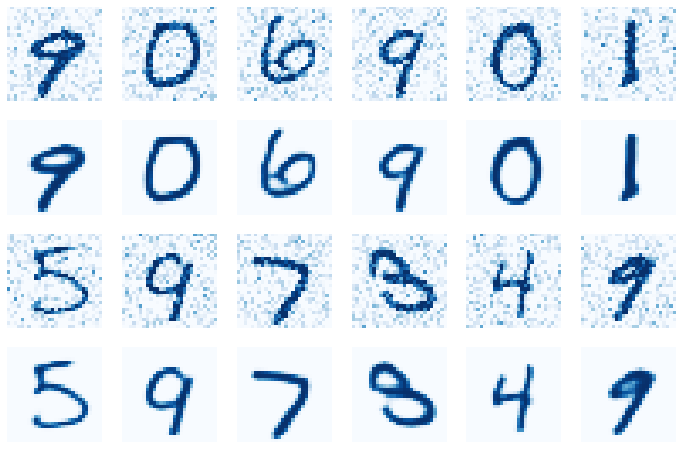

In [62]:
display(2, 6, test_images,test_denoised, check=True )

## Model
More complicated architecture. What's different from last Model Architecture:
* Conv2DTranspose layer
* No UpSampling2D layer
* Skip connection for the last model
* BatchNormalization and MaxPool2D

## Deconvolution (Conv2DTranspose)
![TransposeConvolution](https://classic.d2l.ai/_images/trans_conv.svg)

**Conv2DTranspose** layer performs the inverse of that of **Conv2D**. It performs deconvolution, and it is much better than **UpSampling**. **UpSampling** layer copies the values to the upscaled dimension. But deconvolution layer can combine the upsampling and convolution in one layer.

**Cons:**
[Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/). <br>
**Skip connection in resnet**
![SKIP CONNECTION](https://cdn-images-1.medium.com/max/800/1*SP6KSRdom6hu4kUxpdXgiQ.png)

Research paper: [Image Restoration Using Convolutional Auto-encoders with Symmetric Skip Connections](https://arxiv.org/pdf/1606.08921.pdf).



***Image denoising work better with MSE loss Deconvolution Work better rather than UpSampling except checkerboard artifacts problem***

***Here another model incorporating OOP concept***


**Define a convolutional autoencoder**
A convolutional autoencoder using Conv2D layers in the encoder, and Conv2DTranspose layers in the decoder

In [63]:
from tensorflow.keras import layers, losses

class Denoise(Model):
    '''__init__ constructor in OOP
    This method called when an object is created from the class and 
    it allow the class to initialize the attributes of a class.
    
    super()function used to give access to 
    methods and properties of a parent or sibling class
    
    '''
    def __init__(self): 
        super(Denoise, self).__init__() 
        #encoder
        self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
        #decoder
        self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [64]:
autoencoder.compile(optimizer='rmsprop', loss=losses.MeanSquaredError())


In [65]:
history=autoencoder.fit(noisy_train_data,train_data,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data= (noisy_test_data, test_data))

Epoch 1/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0572 - val_loss: 0.0135
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 3/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 4/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 5/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 6/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 7/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 8/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 9/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 10/10
235/235 [==============================] - 2s 6ms/step - loss: 0.0046 - val_loss: 0.0044

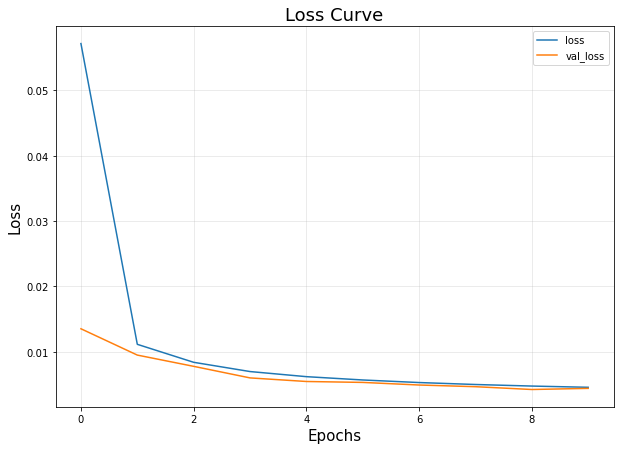

In [66]:
plot_diag(history)

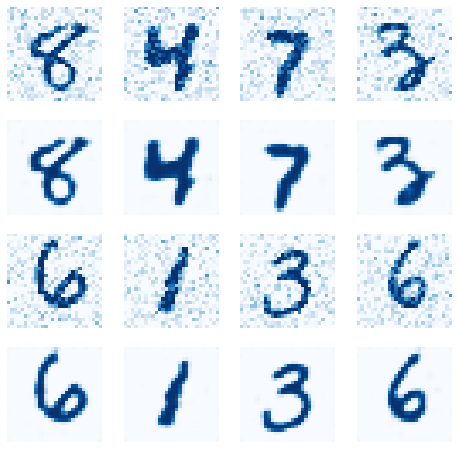

In [67]:
# Select few random test images
num_imgs = 45
rand = np.random.randint(1, 100)
test_images = noisy_test_data[rand:rand+num_imgs] # slicing
test_denoised = autoencoder.predict(test_images) # predict
display(2, 4, test_images, test_denoised, check=True)

In [68]:
#LeakyRelu allow small gradient when any unit is deactive
#usefull for generative models
#Takes input as list of tensors, all of the same shape, and returns a 
#single tensor with same shape
from keras.layers import  Conv2DTranspose, BatchNormalization, add, LeakyReLU
from keras.optimizers import Adam

In [69]:
#print(cifar_train.shape)
size=32
channel=3

In [70]:
# Encoder 

inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x) #standarized the inputs
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
# skip connection for decoder
#convey info, mitigate exploding and and vanishing
#gradient problem
# make activations/output of units/layer not equal 0
skip = Conv2D(32, 3, padding='same')(x) 
x = LeakyReLU()(skip)  
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder
#Conv2DTranspose, the layer will be initialized with 
#random weights that will learn 
#how to effectively upsample with detail during training.
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x) #normalize x into 0 to 1
x = Dropout(0.5)(x)
#Upsampling and Convolution in one layer
#a crude understanding
x = Conv2DTranspose(32, 3, padding='same')(x) 
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder2 = Model(inputs, decoded)
autoencoder2.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')
autoencoder2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 32)   896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 32, 32, 32)   128         conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 16, 16, 32)   0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [71]:
# Training
epochs = 25
batch_size = 256

history2 = autoencoder2.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test))

Epoch 1/25
196/196 [==============================] - 4s 18ms/step - loss: 0.6450 - val_loss: 0.6387
Epoch 2/25
196/196 [==============================] - 3s 17ms/step - loss: 0.5867 - val_loss: 0.5915
Epoch 3/25
196/196 [==============================] - 3s 17ms/step - loss: 0.5758 - val_loss: 0.5711
Epoch 4/25
196/196 [==============================] - 3s 17ms/step - loss: 0.5711 - val_loss: 0.5652
Epoch 5/25
196/196 [==============================] - 3s 17ms/step - loss: 0.5684 - val_loss: 0.5633
Epoch 6/25
196/196 [==============================] - 3s 17ms/step - loss: 0.5667 - val_loss: 0.5623
Epoch 7/25
196/196 [==============================] - 4s 18ms/step - loss: 0.5655 - val_loss: 0.5615
Epoch 8/25
196/196 [==============================] - 4s 18ms/step - loss: 0.5646 - val_loss: 0.5611
Epoch 9/25
196/196 [==============================] - 3s 17ms/step - loss: 0.5638 - val_loss: 0.5605
Epoch 10/25
196/196 [==============================] - 4s 18ms/step - loss: 0.5632 - val_lo

In [72]:

#store both architechture and weights in hierarchical dataformat
#contains multidimensional arrays
# saving whole model
autoencoder2.save('autoencoder_model.h5')
 
# loading whole model
from keras.models import load_model
model2 = load_model('autoencoder_model.h5')

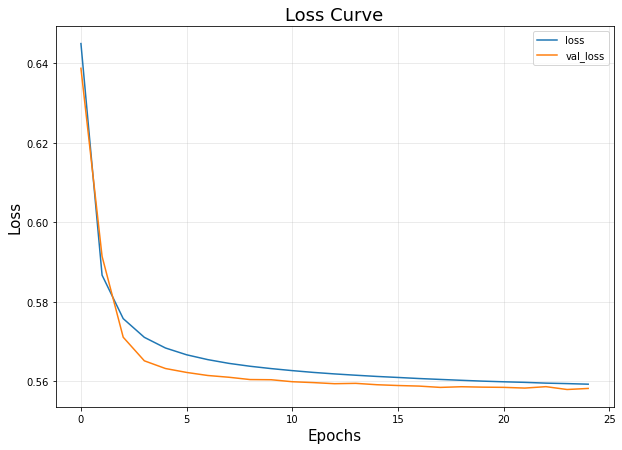

In [73]:
plot_diag(history2)

In [74]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, cifar_test_noise.shape[0]-48) 

cifar_test_images = cifar_test_noise[rand:rand+num_imgs] # slicing
cifar_test_denoised = autoencoder2.predict(cifar_test_images) # predict

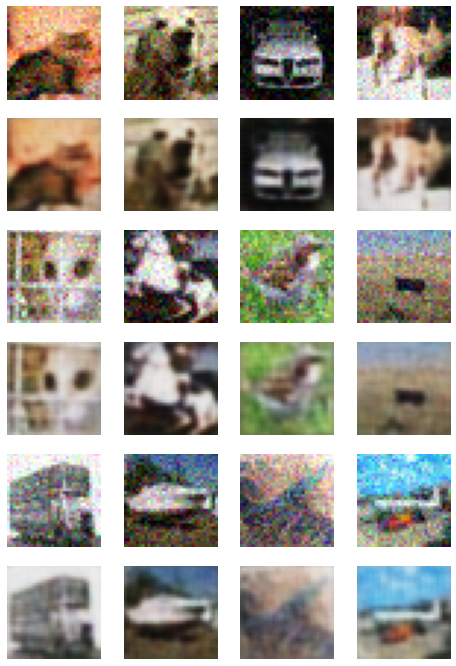

In [75]:
# Visualize test images with their denoised images
display(3, 4, cifar_test_images,cifar_test_denoised)